https://www.kaggle.com/competitions/aerial-cactus-identification

In [1]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.preprocessing import image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from tqdm import tqdm

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from keras.optimizers import SGD
import cv2
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.models import load_model

from keras.utils import np_utils

from keras import applications

from keras import optimizers
from keras.models import Sequential,Model,load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D,GlobalAveragePooling2D
from keras.callbacks import TensorBoard,ReduceLROnPlateau,ModelCheckpoint

Using TensorFlow backend.


In [2]:
import os
# print(os.listdir("../input/test/test/"))

In [3]:
path = "../input/"
train=pd.read_csv(path+'train.csv')
test = pd.read_csv(path+'sample_submission.csv')

In [4]:
test.head()

,id,has_cactus
0,000940378805c44108d287872b2f04ce.jpg,0.5
1,0017242f54ececa4512b4d7937d1e21e.jpg,0.5
2,001ee6d8564003107853118ab87df407.jpg,0.5
3,002e175c3c1e060769475f52182583d0.jpg,0.5
4,0036e44a7e8f7218e9bc7bf8137e4943.jpg,0.5


In [5]:
# As it is a multi-class classification problem (3 classes), we will one-hot encode the target variable.
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
labelencoder = LabelEncoder()
train['has_cactus_en'] = labelencoder.fit_transform(train['has_cactus'])



print(train['has_cactus'].value_counts())
print(train['has_cactus'].value_counts())


y=train['has_cactus']

1    13136
0     4364
Name: has_cactus, dtype: int64
1    13136
0     4364
Name: has_cactus, dtype: int64


In [6]:
train.has_cactus.value_counts()

1    13136
0     4364
Name: has_cactus, dtype: int64

In [7]:
def load_images(path, df):
    train_image = []
    for i in tqdm(range(df.shape[0])):
        try:
#             print(df_image_path+df['id'][i])
            img = cv2.imread((path+df['id'][i]))
            img = cv2.resize(img, (64,64))

#             img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            img = image.img_to_array(img)
            img = img/255
            train_image.append(img)
        except OSError:
            print(df['id'][i])
    image_array = np.array(train_image)   
    return image_array
        
            
train_image_path = '../input/train/train/'
test_image_path  = '../input/test/test/'

X = load_images(train_image_path,train)
test_images = load_images(test_image_path, test)


100%|██████████| 4000/4000 [00:06<00:00, 594.10it/s]


In [8]:
# test_image = []
# for i in tqdm(range(test.shape[0])):
# # for i in range(0,1):
# #     try:
#     img = cv2.imread((image_path+test['image'][i]))
#     img = cv2.resize(img, (200,120))
# #     img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#     img = image.img_to_array(img)
#     img = img/255
    
#     test_image.append(img)
# #     except OSError:
# #         print(train['file_path'][i])
# test_images = np.array(test_image)

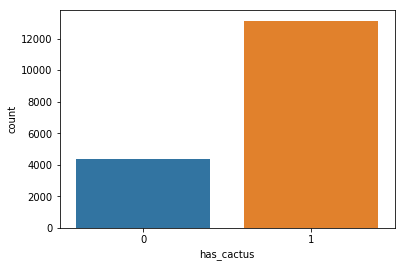

In [9]:
import seaborn as sns
sns.countplot(train['has_cactus'])

In [10]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', np.unique(y), y)
class_weights

array([2.00504125, 0.6661084 ])

In [11]:
# Normalize the data
# X = X / 255.0
# test = test / 255.0



In [12]:
# Step 4: Creating a validation set from the training data.

X_train, X_test, y_train, y_test_class = train_test_split(X, y, random_state=42, test_size=0.2)


In [13]:

y_train = pd.get_dummies(y_train)
y_test = pd.get_dummies(y_test_class)


In [14]:
# Step 5: Define the model structure.

# We will create a simple architecture with 2 convolutional layers, one dense hidden layer and an output layer.

model = Sequential()
# model.add(Conv2D(64, kernel_size=(3, 3), padding='same',activation='relu',input_shape=(200,200,3)))
# model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3), padding="same",  activation='relu',input_shape=(64,64,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))

# (CONV => RELU) * 2 => POOL
model.add(Conv2D(64, (3, 3), padding="same", activation='relu' ))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), padding="same", activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
          
          
# (CONV => RELU) * 2 => POOL
model.add(Conv2D(128, (3, 3), padding="same", activation='relu' ))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), padding="same", activation='relu' ))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
          
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.50))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(2, activation='softmax'))

In [15]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 21, 21, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 21, 21, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 21, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 21, 21, 64)        256       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 21, 21, 64)        36928     
__________

In [16]:
# Next, we will compile the model we’ve created.
opt = SGD(lr=1e-3, momentum=0.9, decay=1e-3 / 25)
model.compile(loss='binary_crossentropy',optimizer=opt,metrics=['accuracy'])


In [17]:
# Data Augmentation
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

datagen = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

datagen.fit(X_train)
print('augmentation')

augmentation


In [18]:
# Step 6: Training the model.

# In this step, we will train the model on the training set images and validate it using, you guessed it, the validation set.
batch_size = 200
# results  = model.fit(X_train, y_train, epochs=3, validation_data=(X_test, y_test))

results  = model.fit_generator(datagen.flow(X_train, y_train, batch_size = batch_size), epochs=1, 
                              steps_per_epoch=X_train.shape[0] // batch_size, 
                              validation_data=(X_test, y_test),
                             class_weight = class_weights)
print(' class weight')

Epoch 1/1
70/70 [==============================] - 15s 212ms/step - loss: 0.4707 - acc: 0.8201 - val_loss: 0.2631 - val_acc: 0.8837
 class weight


In [19]:
type(model.history)

keras.callbacks.History

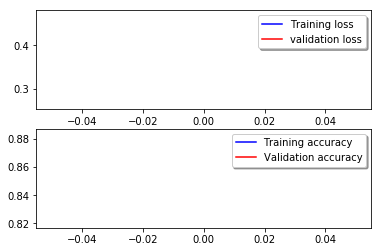

In [20]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(results.history['loss'], color='b', label="Training loss")
ax[0].plot(results.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(results.history['acc'], color='b', label="Training accuracy")
ax[1].plot(results.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [21]:
# Step 7: Find Accuracy
final_loss, final_acc = model.evaluate(X_test, y_test, verbose=0)
print("Final loss: {0:.4f}, final accuracy: {1:.4f}".format(final_loss, final_acc))

Final loss: 0.2631, final accuracy: 0.8837


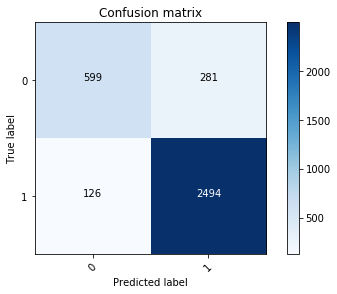

In [22]:

# Look at confusion matrix 
import itertools
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes)) 
    plt.xticks(tick_marks, classes , rotation=45)
    plt.yticks(tick_marks, classes)


    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict_classes(X_test) 

# compute the confusion matrix
confusion_mtx = confusion_matrix(y_test_class, Y_pred) 
confusion_mtx
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(0,2)) 

In [23]:
base_cnn_pred  = model.predict_classes(test_images)

In [24]:
base_model = applications.resnet50.ResNet50(weights= None, include_top=False, input_shape= (64,64,3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
predictions = Dense(2, activation= 'softmax')(x)
model = Model(inputs = base_model.input, outputs = predictions)
from keras.optimizers import SGD, Adam
# sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
adam = Adam(lr=0.0001)
model.compile(optimizer= adam, loss='categorical_crossentropy', metrics=['accuracy'])

# model.fit(X_train, Y_train, epochs = 100, batch_size = 64)

model.fit_generator(datagen.flow(X_train, y_train, batch_size = batch_size), epochs=100, 
                              steps_per_epoch=X_train.shape[0] // batch_size, 
                              validation_data=(X_test, y_test),
                             class_weight = class_weights)

/opt/conda/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Epoch 1/100
70/70 [==============================] - 32s 457ms/step - loss: 0.4707 - acc: 0.8151 - val_loss: 0.3561 - val_acc: 0.8760
Epoch 2/100
70/70 [==============================] - 16s 227ms/step - loss: 0.3383 - acc: 0.8733 - val_loss: 0.3763 - val_acc: 0.8889
Epoch 3/100
70/70 [==============================] - 17s 242ms/step - loss: 0.3064 - acc: 0.8880 - val_loss: 0.4455 - val_acc: 0.8703
Epoch 4/100
70/70 [==============================] - 17s 240ms/step - loss: 0.2741 - acc: 0.8980 - val_loss: 0.2606 - val_acc: 0.9014
Epoch 5/100
70/70 [==============================] - 17s 240ms/step - loss: 0.2522 - acc: 0.9034 - val_loss: 0.2388 - val_acc: 0.9231
Epoch 6/100
70/70 [==============================] - 17s 242ms/step - loss: 0.2328 - acc: 0.9151 - val_loss: 0.2293 - val_acc: 0.9257
Epoch 7/100
70/70 [==============================] - 17s 241ms/step - loss: 0.2141 - acc: 0.9186 - val_loss: 0.2400 - val_acc: 0.9266
Epoch 8/100
70/70 [==============================] - 17s 241ms

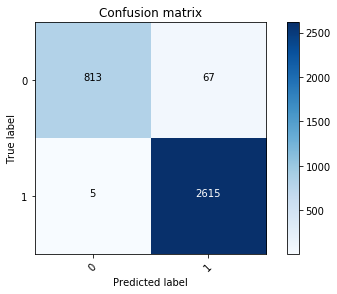

In [25]:
# Predict the values from the validation dataset
Y_pred = model.predict(X_test) 
type(Y_pred)
Y_pred = Y_pred.argmax(axis=-1)


# # compute the confusion matrix
confusion_mtx = confusion_matrix(y_test_class, Y_pred) 
confusion_mtx
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(0,2)) 

In [26]:
resnet_pred =  model.predict(test_images)
# resnet_pred = resnet_pred.argmax(axis=-1)


# final_predictions =  (base_cnn_pred + resnet_pred) / 2
# final_predictions = np.where(final_predictions >= 0.5, 1, 0)
test['has_cactus'] = resnet_pred

test[['id','has_cactus']]
test.to_csv('output.csv',  index=False)